In [1]:
import torch
import utils
import nets_LV
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from tqdm import tqdm

/Users/jonase/opt/miniconda3/envs/lsr_mood/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jonas-van-elburg (vqvaeanomaly). Use `wandb login --relogin` to force relogin
/Users/jonase/opt/miniconda3/envs/lsr_mood/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jonase/opt/miniconda3/envs/lsr_mood/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/jona

In [2]:
transform_pipeline = transforms.Compose([
    transforms.Resize((128, 128)),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=.3, hue=.2),
    # transforms.RandomRotation(degrees=(-10, 10)),
    transforms.ToTensor()
])

In [47]:
# lambda_set = '../../../../../project/gpuuva022/shared/AnomalyDetection/FFHQ_Data/FFHQ_data/l_tuning'
images_pixel_score_path = '../../data/thresholding_images/'#'/home/lcur1737/AnomalyDetection/data/thresholding_images'

# val_dataset = ImageFolder(lambda_set, transform=transform_pipeline)
# val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
pixel_score_set = ImageFolder(images_pixel_score_path, transform=transform_pipeline)
pixel_score_loader = DataLoader(pixel_score_set, batch_size=1, shuffle=True)

In [48]:
vqvae_checkpoint_path = '../../checkpoints/ffhq_continued_020.pt' #'/home/lcur1737/AnomalyDetection/src/checkpoints/VQVAE/ffhq_continued_020.pt'
ar_checkpoint_path = '../../checkpoints/ffhq_ar_030.pt' #'/home/lcur1737/AnomalyDetection/src/checkpoints/AR/ffhq_ar_030.pt'

In [49]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
vq_model = nets_LV.VQVAE(
    d=3,
    n_channels=(16, 32, 64, 256),
    code_size=128,
    n_res_block=2,
    dropout_p=.1
).to(device)

vqvae_checkpoint = torch.load(vqvae_checkpoint_path, map_location=device)
vq_model.load_state_dict(vqvae_checkpoint["model"])
# vq_model = vq_model.to(device)

ar_model = nets_LV.VQLatentSNAIL(
    feature_extractor_model=vq_model,
    shape=(16, 16),
    n_block=4,
    n_res_block=4,
    n_channels=128
).to(device)

ar_checkpoint = torch.load(ar_checkpoint_path, map_location=device)

ar_model.load_state_dict(ar_checkpoint['model'])

<All keys matched successfully>

# Sample wise score threshold

In [50]:
pred = []
accuracy = []
ar_model.eval()

thresholds = np.linspace(1,20,50)


# loaded_dataloader = tqdm(val_dataloader)
# print('Starting the measurements')
# for thr in thresholds:
#     for batchX, batchY in loaded_dataloader:
#         with torch.no_grad():
#             # codes = ar_model.retrieve_codes(batchX).flatten(1)
#             loss = ar_model.loss(batchX, reduction='none')['loss'].flatten(1)
            
#             score = torch.sum(loss*(loss>thr), 1).float()
#             pred.append([score.cpu().numpy()])
#         break
#     break


# Find pixel score threshold

In [51]:
def reconstruct(n, img, threshold_log_p = 5):
    """ Generates n reconstructions for each image in img.
    Resamples latent variables with cross-entropy > threshold
    Returns corrected images and associated latent variables"""
          
    #Use VQ-VAE to encode original image
    codes = ar_model.retrieve_codes(img)
    code_size = codes.shape[-2:]
    
    with torch.no_grad():
        samples = codes.clone().unsqueeze(1).repeat(1,n,1,1).reshape(img.shape[0]*n,*code_size)
        logits = ar_model.forward_latent(samples)

        for r in range(code_size[0]):
            for c in range(code_size[1]):
                code_logits = logits[:, :, r, c]

                loss = F.cross_entropy(code_logits, samples[:, r, c], reduction='none')
                probs = F.softmax(code_logits, dim=1)

                samples[loss > threshold_log_p, r, c] = torch.multinomial(probs, 1).squeeze(-1)[loss > threshold_log_p]
                # print(sum(loss > threshold_log_p))

        z = vq_model.codebook.embedding(samples.unsqueeze(1))
        z = z.squeeze(1).permute(0,3,1,2).contiguous()
        
        # Split the calculation in batches
        x_tilde = []
        for i in range(img.shape[0]):
            x_tilde.append(vq_model.decode(z[i*n:(i+1)*n]))
        x_tilde = torch.cat(x_tilde)
        
        
    return x_tilde.reshape(3,n,*img.shape[-2:]), samples.reshape(img.shape[0],n,*code_size)

reconstructions = []

# for X,_ in loaded_dataloader:
#     x_tilde, latent_sample = reconstruct(n=15,img=X, threshold_log_p=5)
#     reconstructions.append(x_tilde)

## 5 images experiment

In [69]:
import matplotlib.pyplot as plt

In [84]:
X = next(iter(pixel_score_loader))[0]


reconstruction500 = torch.mean(reconstruct(10,X, threshold_log_p=500)[0], dim=1)
reconstruction20 = torch.mean(reconstruct(10,X, threshold_log_p=20)[0], dim=1)
reconstruction10 = torch.mean(reconstruct(10,X, threshold_log_p=10)[0], dim=1)
reconstruction5 = reconstruct(1,X, threshold_log_p=5)[0]


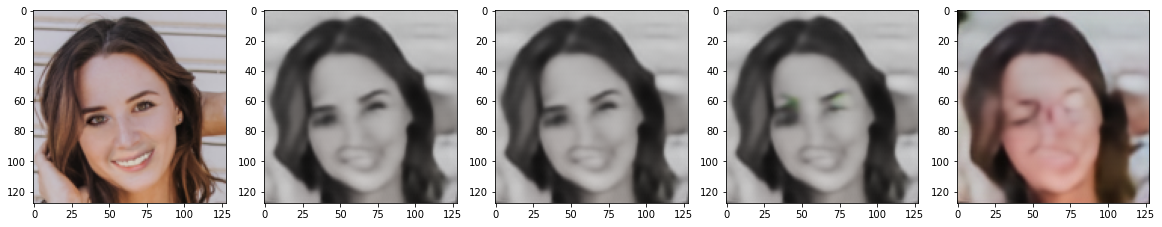

In [85]:
fig, axes = plt.subplots(1,5 , figsize=(20, 10))

axes[0].imshow(X[0].permute(1,2,0))
axes[1].imshow(reconstruction500.squeeze().permute(1,2,0))
axes[2].imshow(reconstruction20.squeeze().permute(1,2,0))
axes[3].imshow(reconstruction10.squeeze().permute(1,2,0))
axes[4].imshow(reconstruction5.squeeze().permute(1,2,0))
plt.show()

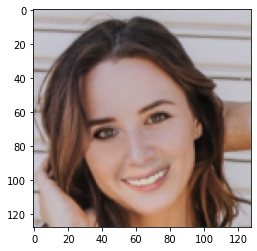

In [53]:
plt.imshow(X[0].permute(1,2,0).cpu().numpy())

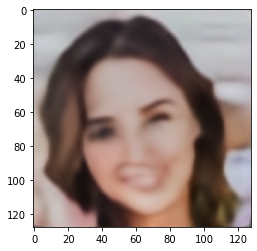

In [54]:
plt.imshow(reconstruction.squeeze().permute(1,2,0).cpu().numpy())